# Work with STAC catalogs on the SURF dCache Storage

## Create a STAC catalog

We search for some assets in the [Sentinel-2 Open Data collection available on AWS](https://registry.opendata.aws/sentinel-2-l2a-cogs/). We query the [Earth Search STAC API end point](https://earth-search.aws.element84.com/v0) using [PySTAC Client](https://pystac-client.readthedocs.io). In order to install this tool, uncomment and run the following cell:

In [1]:
# !pip install pystac-client==0.3.2

In [2]:
from pystac_client import Client

In [3]:
STAC_API_URL = "https://earth-search.aws.element84.com/v0"

client = Client.open(STAC_API_URL)

# search assets
search = client.search(    
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2018-03-16/2018-03-25",
    # query Sentinel-2 tile 5VNK
    query=[
        "sentinel:utm_zone=5",
        "sentinel:latitude_band=V",
        "sentinel:grid_square=NK"
    ]
)

In [4]:
# get all items matching the query
items = search.get_all_items()

We then use [PySTAC](https://pystac.readthedocs.io) to create a STAC catalog where to save the search results.

In [5]:
from pystac import Catalog, Item

In [6]:
# create new catalog
catalog = Catalog(
    id='s2-catalog',
    description='Test catalog for Sentinel-2 data'
)
catalog

ID: s2-catalog
Description: Test catalog for Sentinel-2 data
Rel: root
Target:
Media Type: application/json


In [7]:
# add search results to catalog
catalog.add_items(items)
catalog.describe()

* <Catalog id=s2-catalog>
  * <Item id=S2B_5VNK_20180325_1_L2A>
  * <Item id=S2A_5VNK_20180324_0_L2A>
  * <Item id=S2B_5VNK_20180322_0_L2A>
  * <Item id=S2B_5VNK_20180319_0_L2A>


## Read/write STAC objects

Let's save the catalog (metadata only!) on the dCache storage. For authentication we use a macaroon (see [here](https://github.com/sara-nl/GridScripts/blob/master/get-macaroon) for instructions on how to generate the token), but username/password authentication can also be employed: 

In [8]:
import stac2dcache

stac2dcache.configure(token_filename="macaroon.dat")

We can then read/write PySTAC objects on dCache as:

In [9]:
urlpath = "https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/tmp-sentinel-2-catalog"

# temporary fix for pystac<1.4
catalog._stac_io = stac2dcache.stac_io
catalog.normalize_and_save(
    urlpath,
    catalog_type='SELF_CONTAINED'
)

The catalog is now written to the storage. In order to re-load it into memory:

In [10]:
catalog_url = urlpath + '/catalog.json'

# read catalog from storage
catalog = Catalog.from_file(
    catalog_url, 
    stac_io=stac2dcache.stac_io
)

In [11]:
catalog.describe()

* <Catalog id=s2-catalog>
  * <Item id=S2B_5VNK_20180325_1_L2A>
  * <Item id=S2A_5VNK_20180324_0_L2A>
  * <Item id=S2B_5VNK_20180322_0_L2A>
  * <Item id=S2B_5VNK_20180319_0_L2A>


## Retrieve assets to/from dCache 

Let's now retrieve few assets from the remote servers, and save them to dCache. We download the original XML metadata file and one band file ('B-1') from the MSI.

In [12]:
from stac2dcache.utils import copy_asset

In [13]:
# download assets - from web to storage
for asset_key in ('metadata', 'B01'):
    copy_asset(
        catalog, 
        asset_key, 
        update_catalog=True,  # update the catalog's links to the assets  
        filesystem_to=stac2dcache.fs,
        max_workers=4
    )
    
# save catalog with the updated links
catalog.normalize_and_save(urlpath)

Note that `copy_asset` makes use of multiple processes to download the data (use the `max_workers` argument to set the number of processes spawned).

Files have been saved on the dCache storage. Let's now download one example file from dCache to the local file system for inspection or further processing.

In [14]:
# download an asset - from storage to local filesystem
copy_asset(
    catalog, 
    'B01', 
    item_id='S2B_5VNK_20180319_0_L2A',
    to_uri='./tmp',
    filesystem_from=stac2dcache.fs
)

In [15]:
! ls ./tmp/S2B_5VNK_20180319_0_L2A/B01.tif

./tmp/S2B_5VNK_20180319_0_L2A/B01.tif


## Load assets 

Instead of copying assets locally, STAC2dCache allows to directly load into memory few common file formats:

In [16]:
from stac2dcache.utils import get_asset

In [17]:
# read metadata from storage (as text file)
data = get_asset(
    catalog,
    'metadata',
    'S2B_5VNK_20180319_0_L2A',
    filesystem=stac2dcache.fs
)

# print top five lines
data.splitlines()[:5]

["<?xml version='1.0' encoding='UTF-8'?>",
 '<n1:Level-2A_Tile_ID xmlns:n1="https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd /dpc/app/s2ipf/FORMAT_METADATA_TILE_L1C/02.11.01/scripts/../../../schemas/02.13.01/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd">',
 '  <n1:General_Info>',
 '    <L1C_TILE_ID metadataLevel="Brief">S2B_OPER_MSI_L1C_TL_EPAE_20180319T231157_A005403_T05VNK_N02.06</L1C_TILE_ID>',
 '    <TILE_ID metadataLevel="Brief">S2B_OPER_MSI_L2A_TL_SHIT_20201104T123444_A005403_T05VNK_N00.01</TILE_ID>']

In [18]:
# same for raster data (as xarray object)
data = get_asset(
    catalog,
    'B01',
    'S2B_5VNK_20180319_0_L2A',
    filesystem=stac2dcache.fs
)
data

<xarray.DataArray (band: 1, y: 1830, x: 1830)>
array([[[    0,     0,     0, ...,  5703,  5936,  5016],
        [    0,     0,     0, ...,  6587,  6828,  5825],
        [    0,     0,     0, ...,  6699,  6655,  5496],
        ...,
        [ 9110, 10489,  9932, ...,  1733,  2269,  1933],
        [ 9406, 10773, 10684, ...,  1799,  2759,  2406],
        [ 8260,  9473,  9653, ...,  1170,  1634,  1917]]], dtype=uint16)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5e+05 5.001e+05 5.001e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 7e+06 7e+06 7e+06 ... 6.89e+06 6.89e+06 6.89e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In order to plot the data, [matplotlib](https://matplotlib.org) needs to be installed (uncomment and run the following lines to do that).

In [19]:
# !pip install matplotlib

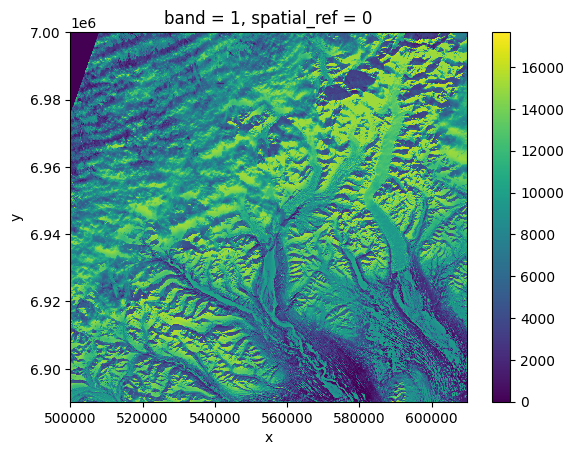

In [20]:
data.plot()

## Use a configuration file

The token for authentication, together with other parameters (such as the dCache WebDAV door), can  be saved in a .json (or .ini) configuration file stored in the directory `~/.config/fsspec/`:

```json
{
    "dcache": {
        "api_url": "https://dcacheview.grid.surfsara.nl:22880/api/v1",
        "webdav_url": "https://webdav.grid.surfsara.nl:2880",
        "token": "<DCACHE_TOKEN>",
        "block_size": 0
    }
}
```

Once setup as above, STAC2dCache will be able to read/write URL-paths that include the "dcache" protocol without specifying the `stac_io`/`filesystem` arguments: 

In [21]:
catalog_url = "dcache://pnfs/grid.sara.nl/data/eratosthenes/disk/tmp-sentinel-2-catalog/catalog.json"

# read catalog from storage
catalog = Catalog.from_file(catalog_url) 
catalog.describe()

* <Catalog id=s2-catalog>
  * <Item id=S2B_5VNK_20180325_1_L2A>
  * <Item id=S2A_5VNK_20180324_0_L2A>
  * <Item id=S2B_5VNK_20180322_0_L2A>
  * <Item id=S2B_5VNK_20180319_0_L2A>


In [22]:
data = get_asset(
    catalog,
    'B01',
    'S2B_5VNK_20180319_0_L2A'
)
data

<xarray.DataArray (band: 1, y: 1830, x: 1830)>
array([[[    0,     0,     0, ...,  5703,  5936,  5016],
        [    0,     0,     0, ...,  6587,  6828,  5825],
        [    0,     0,     0, ...,  6699,  6655,  5496],
        ...,
        [ 9110, 10489,  9932, ...,  1733,  2269,  1933],
        [ 9406, 10773, 10684, ...,  1799,  2759,  2406],
        [ 8260,  9473,  9653, ...,  1170,  1634,  1917]]], dtype=uint16)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5e+05 5.001e+05 5.001e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 7e+06 7e+06 7e+06 ... 6.89e+06 6.89e+06 6.89e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

More info on the use of configuration files for the underlying Filesystem Spec library [here](https://filesystem-spec.readthedocs.io/en/latest/features.html#configuration).

## Retrieve assets from API endpoints that require authentication

Below we demontrate how to search Sentinel-1 GRD data from the Alaska Satellite Facility (ASF) enpoint that is part of the [NASA Common Metadata Repository (CMR) STAC catalog](https://cmr.earthdata.nasa.gov/search). While the catalog is publicly accessible, authentication is required in order to download the assets.

As for Sentinel-2, we first search the available assets with PySTAC Client:

In [23]:
STAC_API_URL = "https://cmr.earthdata.nasa.gov/stac/ASF"
bbox = [4.6, 52.3, 4.7, 52.4]  # (min lon, min lat, max lon, max lat) AMS area

client = Client.open(STAC_API_URL)

# search assets
search = client.search(    
    collections=[
        "SENTINEL-1A_DP_GRD_HIGH.v1",
        "SENTINEL-1B_DP_GRD_HIGH.v1"
    ],
    datetime="2019-01-02",
    bbox=bbox
)

In [24]:
# get all items matching the query
items = search.get_all_items()

In [25]:
len(items)

1

We build a catalog with the found items. Note that we have limited our search to a single item due to the large size of S1 GRD data.

In [26]:
catalog = Catalog(
    id='s1-catalog',
    description='Test catalog for Sentinel-1 data'
)
catalog.add_items(items)
catalog.describe()

* <Catalog id=s1-catalog>
  * <Item id=S1B_IW_GRDH_1SDV_20190102T055723_20190102T055748_014311_01AA09_29B6-GRD_HD>


In [27]:
urlpath = "dcache://pnfs/grid.sara.nl/data/eratosthenes/disk/tmp-sentinel-1-catalog"

catalog.normalize_and_save(
    urlpath,
    catalog_type='SELF_CONTAINED'
)

To retrieve Sentinel-1 images, we need to authenticate using EarthData login credentials (see [this guide](https://wiki.earthdata.nasa.gov/display/EL/How+To+Register+For+an+EarthData+Login+Profile) for instructions on how to register). Also make sure you authorize all applications related to the Alaska Satellite Facility before downloading the data(see instructions [here](https://wiki.earthdata.nasa.gov/display/EL/How+To+Pre-authorize+an+application)).

After setting up the credentials, we can create a filesystem instance to authenticate on the remote servers in the following way (fill in the blanks):

In [28]:
from getpass import getpass
nasa_fs = stac2dcache.configure_filesystem(
    username=getpass("username: "),
    password=getpass("password: ")
)

username:  ········
password:  ········


We download S1 data to the local file system:

In [29]:
assets = ('browse', 'data')

for asset_key in assets:
    copy_asset(
        catalog, 
        asset_key, 
        filesystem_from=nasa_fs,
        to_uri="./tmp"
    )

In [30]:
! ls ./tmp/S1B_IW_GRDH_1SDV_20190102T055723_20190102T055748_014311_01AA09_29B6-GRD_HD/

S1B_IW_GRDH_1SDV_20190102T055723_20190102T055748_014311_01AA09_29B6.jpg
S1B_IW_GRDH_1SDV_20190102T055723_20190102T055748_014311_01AA09_29B6.zip
